In [1]:
#!pip install ipywidgets > /dev/null

In [2]:
#!pip install matplotlib > /dev/null
#!pip install scikit-learn > /dev/null

In [3]:
#!pip install joblib > /dev/null

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import time

from numpy import mean

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, train_test_split, cross_val_score, cross_validate

from sklearn.metrics import precision_recall_curve, balanced_accuracy_score, precision_score, accuracy_score, recall_score, classification_report, PrecisionRecallDisplay, make_scorer, f1_score, average_precision_score
from sklearn.preprocessing import RobustScaler

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import random

import shap
from lime import lime_tabular
from model import ModelWrapper


In [5]:
np.random.seed(1)

# Data variables and basic functions

In [6]:
df = pd.read_csv('../datasets/creditcard.csv')
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [7]:
df = df.dropna()
df.isnull().sum().max()

0

In [8]:
fraud_percent      = df['Class'].value_counts()[0] / len(df) * 100
not_fraud_percent = df['Class'].value_counts()[1] / len(df) * 100

print("Porcentagem de transações fraudulentas %.2f"%fraud_percent)
print("Porcentagem de transações não fraudulentas %.2f"%not_fraud_percent)

Porcentagem de transações fraudulentas 99.83
Porcentagem de transações não fraudulentas 0.17


In [9]:
X = df.drop('Class', axis=1)
y = df['Class']

In [10]:
default_pos_color = "#008bfb"
data_dict = {
    'logistic_regression_values': [],
    'logistic_regression_lime': [], 
    'logistic_regression_shap': [],
    'random_forest_lime': [],
    'random_forest_shap': [],
    'svm_lime': [],
    'svm_shap': [],
    'mlp_classifier_lime': [],
    'mlp_classifier_shap': [],
    'decision_tree_lime': [],
    'decision_tree_shap': []
}

def save_model_data(model, data, method):
    if isinstance(model, LogisticRegression):
        if method == 'lime': 
            data_dict['logistic_regression_lime'].append(data)
        else:
            if method == 'shap':
                data_dict['logistic_regression_shap'].append(data)
            else:
                data_dict['logistic_regression_values'].append(data)
    elif isinstance(model, RandomForestClassifier):
        if method == 'lime': 
            data_dict['random_forest_lime'].append(data)
        else:
            data_dict['random_forest_shap'].append(data)
    elif isinstance(model, LinearSVC):
        if method == 'lime': 
            data_dict['svm_lime'].append(data)
        else:
            data_dict['svm_shap'].append(data)
    elif isinstance(model, MLPClassifier):
        if method == 'lime': 
            data_dict['mlp_classifier_lime'].append(data)
        else:
            data_dict['mlp_classifier_shap'].append(data)
    elif isinstance(model, DecisionTreeClassifier):
        if method == 'lime': 
            data_dict['decision_tree_lime'].append(data)
        else:
            data_dict['decision_tree_shap'].append(data)
    else:
        print("Unrecognized model type")

In [11]:
def plot_results_logistic_regression_to_file(training_results):

    fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 3), sharey=False)
    fig.tight_layout(pad=3.2)

    for i in range (0, 5):
        
        fraud_sample = training_results['samples'][i]
        
        model = training_results['models'][i]
        avg_model_coeficients = np.mean(abs(model.coef_), axis=0)
        top_indices = np.argsort(avg_model_coeficients)[::-1][:10]

        bars = axes[i].barh(np.arange(10), np.flip(avg_model_coeficients[top_indices]), align='center', color=default_pos_color)

        for j, bar in enumerate(bars):
            axes[i].text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2., \
                    '{:.3f}'.format(np.flip(avg_model_coeficients[top_indices])[j]), \
                    ha='left', va='center', color=default_pos_color)
        
        #axes[i].set_xlabel('Fold {}'.format(i+1))
        axes[i].spines["right"].set_visible(False)
        axes[i].spines["top"].set_visible(False)
        axes[i].set_yticks(np.arange(10))
        axes[i].set_yticklabels(np.flip(fraud_sample.keys()[top_indices]))
        
        data = np.flip(fraud_sample.keys()[top_indices])
        save_model_data(model, data, 'reg')
    
    plt.suptitle("Regressão logística (Pesos do modelo)")
    plt.savefig("../results/new/kaggle/logistic_regression_feature_importance_plot.pdf")
    axes[0].set_ylabel('Nome do preditor')

In [12]:
def plot_lime_results_to_file_for_svm(training_results, plot_title, file_name):

    fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 3), sharey=False)
    fig.tight_layout(pad=3.2)

    for i in range (0, 5):
        fraud_sample = training_results['samples'][i]
        
        model = training_results['models'][i]
        explainer = training_results['lime_explainers'][i]
        
        start = time.time()
        explanation = explainer.explain_instance(
            data_row=fraud_sample,
            predict_fn=model._predict_proba_lr
        )
        end = time.time()
        print(f"Time used to calculate LIME values {end - start} seconds! \n")
        
        feature_names   = []
        feature_weights = []
        
        for index, tup in enumerate(explanation.as_map()[1]):
            feature_names.append(fraud_sample.keys()[tup[0]])
            feature_weights.append(abs(tup[1]))
        
        features_weights = np.array(np.abs(feature_weights)).mean(axis=0)
        top_indices = np.argsort(features_weights)[::-1][:10]
          
        bars = axes[i].barh(np.arange(10), np.flip(feature_weights), align='center', color=default_pos_color)
        
        for j, bar in enumerate(bars):
            axes[i].text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2., \
                    '{:.3f}'.format(np.flip(feature_weights)[j]), \
                    ha='left', va='center', color=default_pos_color)

        #axes[i].set_xlabel('Fold {}'.format(i+1))
        axes[i].spines["right"].set_visible(False)
        axes[i].spines["top"].set_visible(False)
        axes[i].set_yticks(np.arange(10))
        axes[i].set_yticklabels(np.flip(feature_names))
        
        save_model_data(model, np.flip(feature_names), 'lime')

    plt.suptitle(plot_title)
    plt.savefig(file_name)
    axes[0].set_ylabel('Nome do preditor')

In [13]:
def plot_lime_results_to_file(training_results, plot_title, file_name):

    fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 3), sharey=False)
    fig.tight_layout(pad=3.2)

    for i in range (0, 5):
        
        fraud_sample = training_results['samples'][i]
        model = training_results['models'][i]
        explainer = training_results['lime_explainers'][i]
        
        start = time.time()
        explanation = explainer.explain_instance(
            data_row=fraud_sample,
            predict_fn=model.predict_proba
        )
        end = time.time()
        print(f"Time used to calculate LIME values {end - start} seconds! \n")
        
        feature_names   = []
        feature_weights = []
        
        for index, tup in enumerate(explanation.as_map()[1]):
            feature_names.append(fraud_sample.keys()[tup[0]])
            feature_weights.append(abs(tup[1]))
        
        features_weights = np.array(np.abs(feature_weights)).mean(axis=0)
        top_indices = np.argsort(features_weights)[::-1][:10]
        
        bars = axes[i].barh(np.arange(10), np.flip(feature_weights), align='center', color=default_pos_color)
        
        for j, bar in enumerate(bars):
            axes[i].text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2., \
                    '{:.3f}'.format(np.flip(feature_weights)[j]), \
                    ha='left', va='center', color=default_pos_color)

        #axes[i].set_xlabel('Fold {}'.format(i+1))
        axes[i].spines["right"].set_visible(False)
        axes[i].spines["top"].set_visible(False)
        axes[i].set_yticks(np.arange(10))
        axes[i].set_yticklabels(np.flip(feature_names))
        
        save_model_data(model, np.flip(feature_names), 'lime')
    
    plt.suptitle(plot_title)
    plt.savefig(file_name)
    axes[0].set_ylabel('Nome do preditor')

In [14]:
def plot_shap_results_to_file(training_results, plot_title, file_name):

    fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 3), sharey=False)
    fig.tight_layout(pad=3.2)

    for i in range (0, 5):
        
        fraud_sample = training_results['samples'][i]
        
        start = time.time()
        model = training_results['models'][i]
        explainer   = training_results['shap_explainers'][i]
        shap_values = explainer(fraud_sample.values.reshape(1,-1)).values
        end = time.time()
        print(f"Time used to calculate SHAP values {end - start} seconds! \n")
        
        if (shap_values.ndim == 3):
            fraud_shap_values = shap_values[0][:, 1]
            fraud_shap_values_reset = pd.Series(fraud_shap_values, index=pd.Index(fraud_sample.keys()))
            fraud_shap_values_abs = np.abs(fraud_shap_values_reset.values)
            fraud_shap_values_abs = fraud_shap_values_abs.reshape(1, -1)
            mean_shap_values = fraud_shap_values_abs.mean(axis=0)
        else:
            mean_shap_values = np.abs(shap_values).mean(axis=0)

        top_indices = np.argsort(mean_shap_values)[::-1][:10]
        
        bars = axes[i].barh(np.arange(10), np.flip(mean_shap_values[top_indices]), align='center', color=default_pos_color)

        for j, bar in enumerate(bars):
            axes[i].text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2., \
                    '{:.3f}'.format(np.flip(mean_shap_values[top_indices])[j]), \
                    ha='left', va='center', color=default_pos_color)
        
        #axes[i].set_xlabel('Fold {}'.format(i+1))
        axes[i].spines["right"].set_visible(False)
        axes[i].spines["top"].set_visible(False)
        axes[i].set_yticks(np.arange(10))
        axes[i].set_yticklabels(np.flip(    fraud_sample.keys()[top_indices]   ))
        
        data = np.flip(fraud_sample.keys()[top_indices])
        save_model_data(model, data, 'shap')
    
    plt.suptitle(plot_title)
    plt.savefig(file_name)
    axes[0].set_ylabel('Nome do preditor')

# Training

In [15]:
decision_tree_params = {'max_depth': [None, 5, 10], 'random_state':[1]}
random_forest_params = {'n_estimators': [50, 100, 200], 'max_depth': [None, 5, 10], 'random_state':[1], 'n_jobs': [-1]}
logistic_regression_params = {'C': [0.1, 1, 10], 'penalty': ['l2'], 'solver':['newton-cholesky'], 'max_iter':[2000, 5000], 'random_state':[1], 'n_jobs': [-1]}
svm_params = {'C': [0.1, 1, 10], 'random_state':[1], 'dual':[False]}
mlp_params = {'hidden_layer_sizes': [(100,), (50, 50)], 'max_iter':[200, 400], 'random_state':[1]}

In [16]:
decision_tree         = ModelWrapper(DecisionTreeClassifier(), decision_tree_params)
decision_tree_results = decision_tree.train(X, y, "kaggle")

2024-12-25 20:33:02,421 - INFO - Starting to train model DecisionTreeClassifier...
2024-12-25 20:33:02,495 - INFO - Starting to scale data...
2024-12-25 20:33:02,761 - INFO - Finished scaling data. Time used: 0.27 seconds
2024-12-25 20:33:03,146 - INFO - Starting to calculate hyperparameters for DecisionTreeClassifier...
2024-12-25 20:34:12,455 - INFO - Finished hyperparameter calculation. Time used: 69.31 seconds
2024-12-25 20:34:12,456 - INFO - Best hyperparameters: {'max_depth': None, 'random_state': 1}
2024-12-25 20:34:44,337 - INFO - Starting to create SHAP explainer...
2024-12-25 20:34:44,339 - INFO - Finished SHAP explainer creation. Time used: 0.00 seconds
2024-12-25 20:34:44,340 - INFO - Starting to create LIME explainers...
2024-12-25 20:34:48,877 - INFO - Finished to create LIME exaplainers. Time used: 4.54 seconds
2024-12-25 20:34:48,994 - INFO - Starting to scale data...
2024-12-25 20:34:49,249 - INFO - Finished scaling data. Time used: 0.25 seconds
2024-12-25 20:34:49,608

In [17]:
print("Métricas Árvoes de Decisão: \n")

print("Sensibilidade: %f\n"%np.mean(decision_tree_results['sensitivity_scores']))
print("Acurácia balanceada: %f\n"%np.mean(decision_tree_results['balanced_acuracies']))
print("Especificidade: %f\n"%np.mean(decision_tree_results['specificity_scores']))
print("Precisão: %f\n"%np.mean(decision_tree_results['precision_scores']))
print("F1: %f\n"%np.mean(decision_tree_results['f1_scores']))
print("AUPRC: %f\n"%np.mean(decision_tree_results['auprc_scores']))

Métricas Árvoes de Decisão: 

Sensibilidade: 0.778396

Acurácia balanceada: 0.888097

Especificidade: 0.997798

Precisão: 0.380363

F1: 0.510758

AUPRC: 0.296607



In [18]:
logistic_regression         = ModelWrapper(LogisticRegression(), logistic_regression_params)
logistic_regression_results = logistic_regression.train(X, y, "kaggle")

2024-12-25 20:41:20,903 - INFO - Starting to train model LogisticRegression...
2024-12-25 20:41:20,966 - INFO - Starting to scale data...
2024-12-25 20:41:21,221 - INFO - Finished scaling data. Time used: 0.25 seconds
2024-12-25 20:41:21,548 - INFO - Starting to calculate hyperparameters for LogisticRegression...
2024-12-25 20:41:35,837 - INFO - Finished hyperparameter calculation. Time used: 14.29 seconds
2024-12-25 20:41:35,839 - INFO - Best hyperparameters: {'C': 1, 'max_iter': 2000, 'n_jobs': -1, 'penalty': 'l2', 'random_state': 1, 'solver': 'newton-cholesky'}
2024-12-25 20:41:37,419 - INFO - Starting to create SHAP explainer...
2024-12-25 20:41:37,423 - INFO - Finished SHAP explainer creation. Time used: 0.00 seconds
2024-12-25 20:41:37,423 - INFO - Starting to create LIME explainers...
2024-12-25 20:41:40,533 - INFO - Finished to create LIME exaplainers. Time used: 3.11 seconds
2024-12-25 20:41:40,636 - INFO - Starting to scale data...
2024-12-25 20:41:40,880 - INFO - Finished sc

In [19]:
print("Métricas Regressão Logística: \n")

print("Sensibilidade: %f\n"%np.mean(logistic_regression_results['sensitivity_scores']))
print("Acurácia balanceada: %f\n"%np.mean(logistic_regression_results['balanced_acuracies']))
print("Especificidade: %f\n"%np.mean(logistic_regression_results['specificity_scores']))
print("Precisão: %f\n"%np.mean(logistic_regression_results['precision_scores']))
print("F1: %f\n"%np.mean(logistic_regression_results['f1_scores']))
print("AUPRC: %f\n"%np.mean(logistic_regression_results['auprc_scores']))

Métricas Regressão Logística: 

Sensibilidade: 0.908514

Acurácia balanceada: 0.942307

Especificidade: 0.976100

Precisão: 0.061797

F1: 0.115713

AUPRC: 0.056329



In [20]:
random_forest         = ModelWrapper(RandomForestClassifier(), random_forest_params)
random_forest_results = random_forest.train(X, y, "kaggle")

2024-12-25 20:43:00,046 - INFO - Starting to train model RandomForestClassifier...
2024-12-25 20:43:00,106 - INFO - Starting to scale data...
2024-12-25 20:43:00,355 - INFO - Finished scaling data. Time used: 0.25 seconds
2024-12-25 20:43:00,673 - INFO - Starting to calculate hyperparameters for RandomForestClassifier...
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
2024-12-25 21:03:44,314 - INFO - Finished hyperparameter calculation. Time used: 1243.64 seconds
2024-12-25 21:03:44,316 - INFO - Best hyperparameters: {'max_depth': None, 'n_estimators': 100, 'n_jobs': -1, 'random_state': 1}
2024-12-25 21:05:11,115 - INFO - Starting to create SHAP explainer...
2024-12-25 21:05:11,117 - INFO - Finished SHAP explainer creation. Time used: 0.00 seconds
2024-12-25 21:05:11,118 - INFO - Starting to create LIME explainers...
2024-12-25 21:05:14,202 - INFO - Finished to create LIME exaplainers. Time used: 3.08 se

In [21]:
print("Métricas Floresta Aleatória: \n")

print("Sensibilidade: %f\n"%np.mean(random_forest_results['sensitivity_scores']))
print("Acurácia balanceada: %f\n"%np.mean(random_forest_results['balanced_acuracies']))
print("Especificidade: %f\n"%np.mean(random_forest_results['specificity_scores']))
print("Precisão: %f\n"%np.mean(random_forest_results['precision_scores']))
print("F1: %f\n"%np.mean(random_forest_results['f1_scores']))
print("AUPRC: %f\n"%np.mean(random_forest_results['auprc_scores']))

Métricas Floresta Aleatória: 

Sensibilidade: 0.817069

Acurácia balanceada: 0.908457

Especificidade: 0.999845

Precisão: 0.902486

F1: 0.857390

AUPRC: 0.737914



In [22]:
SVM         = ModelWrapper(LinearSVC(), svm_params)
SVM_results = SVM.train(X, y, "kaggle")

2024-12-25 22:42:01,993 - INFO - Starting to train model LinearSVC...
2024-12-25 22:42:02,058 - INFO - Starting to scale data...
2024-12-25 22:42:02,318 - INFO - Finished scaling data. Time used: 0.26 seconds
2024-12-25 22:42:02,668 - INFO - Starting to calculate hyperparameters for LinearSVC...
2024-12-25 22:42:18,976 - INFO - Finished hyperparameter calculation. Time used: 16.31 seconds
2024-12-25 22:42:18,977 - INFO - Best hyperparameters: {'C': 1, 'dual': False, 'random_state': 1}
2024-12-25 22:42:22,016 - INFO - Starting to create SHAP explainer...
2024-12-25 22:42:22,018 - INFO - Finished SHAP explainer creation. Time used: 0.00 seconds
2024-12-25 22:42:22,019 - INFO - Starting to create LIME explainers...
2024-12-25 22:42:25,201 - INFO - Finished to create LIME exaplainers. Time used: 3.18 seconds
2024-12-25 22:42:25,308 - INFO - Starting to scale data...
2024-12-25 22:42:25,557 - INFO - Finished scaling data. Time used: 0.25 seconds
2024-12-25 22:42:25,981 - INFO - Starting to 

In [23]:
print("Métricas SVM: \n")

print("Sensibilidade: %f\n"%np.mean(SVM_results['sensitivity_scores']))
print("Acurácia balanceada: %f\n"%np.mean(SVM_results['balanced_acuracies']))
print("Especificidade: %f\n"%np.mean(SVM_results['specificity_scores']))
print("Precisão: %f\n"%np.mean(SVM_results['precision_scores']))
print("F1: %f\n"%np.mean(SVM_results['f1_scores']))
print("AUPRC: %f\n"%np.mean(SVM_results['auprc_scores']))

Métricas SVM: 

Sensibilidade: 0.906494

Acurácia balanceada: 0.943636

Especificidade: 0.980778

Precisão: 0.075610

F1: 0.139557

AUPRC: 0.068763



In [24]:
mlp         = ModelWrapper(MLPClassifier(), mlp_params)
mlp_results = mlp.train(X, y, "kaggle")

2024-12-25 22:43:54,697 - INFO - Starting to train model MLPClassifier...
2024-12-25 22:43:54,764 - INFO - Starting to scale data...
2024-12-25 22:43:55,010 - INFO - Finished scaling data. Time used: 0.25 seconds
2024-12-25 22:43:55,325 - INFO - Starting to calculate hyperparameters for MLPClassifier...
2024-12-25 22:47:58,963 - INFO - Finished hyperparameter calculation. Time used: 243.64 seconds
2024-12-25 22:47:58,964 - INFO - Best hyperparameters: {'hidden_layer_sizes': (50, 50), 'max_iter': 200, 'random_state': 1}
2024-12-25 22:49:06,643 - INFO - Starting to create SHAP explainer...
2024-12-25 22:49:06,645 - INFO - Finished SHAP explainer creation. Time used: 0.00 seconds
2024-12-25 22:49:06,646 - INFO - Starting to create LIME explainers...
2024-12-25 22:49:09,785 - INFO - Finished to create LIME exaplainers. Time used: 3.14 seconds
2024-12-25 22:49:09,927 - INFO - Starting to scale data...
2024-12-25 22:49:10,170 - INFO - Finished scaling data. Time used: 0.24 seconds
2024-12-25

In [25]:
print("Métricas ANN: \n")

print("Sensibilidade: %f\n"%np.mean(mlp_results['sensitivity_scores']))
print("Acurácia balanceada: %f\n"%np.mean(mlp_results['balanced_acuracies']))
print("Especificidade: %f\n"%np.mean(mlp_results['specificity_scores']))
print("Precisão: %f\n"%np.mean(mlp_results['precision_scores']))
print("F1: %f\n"%np.mean(mlp_results['f1_scores']))
print("AUPRC: %f\n"%np.mean(mlp_results['auprc_scores']))

Métricas ANN: 

Sensibilidade: 0.794702

Acurácia balanceada: 0.897128

Especificidade: 0.999553

Precisão: 0.759336

F1: 0.775506

AUPRC: 0.604053



# Results

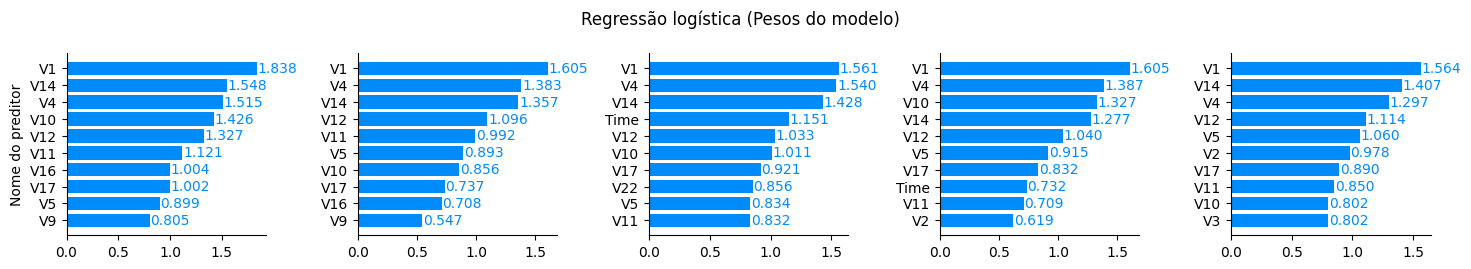

In [26]:
plot_results_logistic_regression_to_file(logistic_regression_results)

## SHAP plots

Time used to calculate SHAP values 2.3559823036193848 seconds! 

Time used to calculate SHAP values 0.013579368591308594 seconds! 

Time used to calculate SHAP values 0.013672590255737305 seconds! 

Time used to calculate SHAP values 0.013632774353027344 seconds! 

Time used to calculate SHAP values 0.013585329055786133 seconds! 



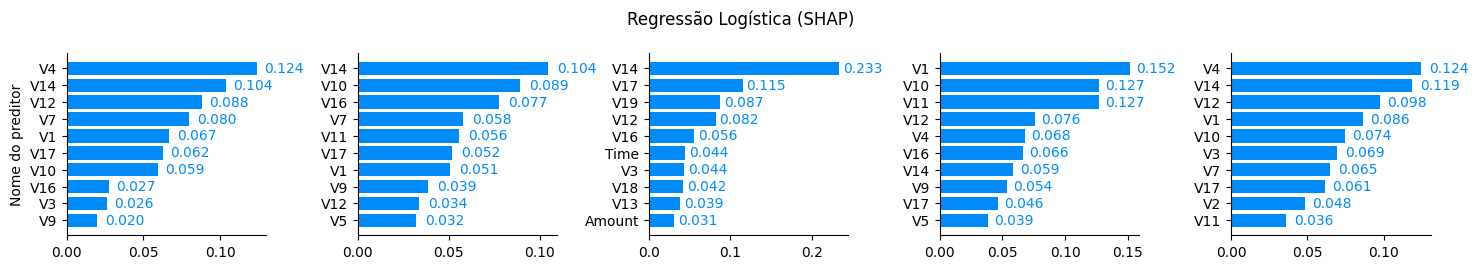

In [27]:
plot_shap_results_to_file(logistic_regression_results, "Regressão Logística (SHAP)", "../results/new/kaggle/logistic_regression_feature_importance_plot(shap).pdf")

Time used to calculate SHAP values 0.01750349998474121 seconds! 

Time used to calculate SHAP values 0.017243623733520508 seconds! 

Time used to calculate SHAP values 0.01750326156616211 seconds! 

Time used to calculate SHAP values 0.01730179786682129 seconds! 

Time used to calculate SHAP values 0.016811609268188477 seconds! 



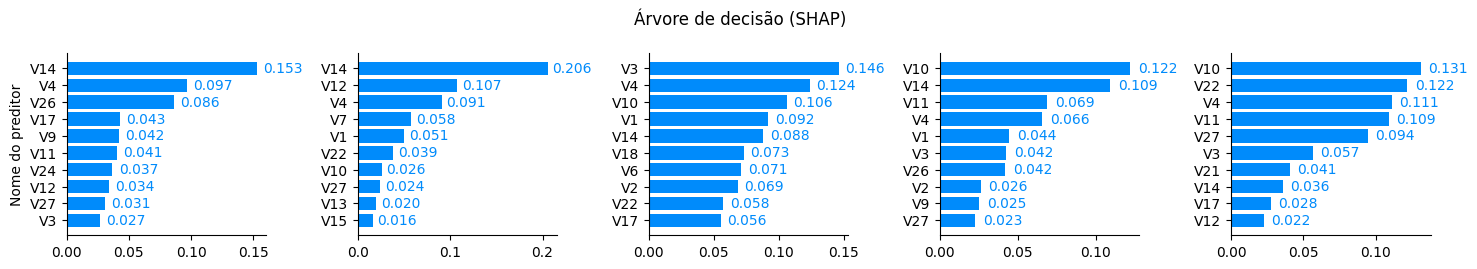

In [28]:
plot_shap_results_to_file(decision_tree_results, "Árvore de decisão (SHAP)", "../results/new/kaggle/decision_tree_feature_importance_plot(shap).pdf")

Time used to calculate SHAP values 0.27214527130126953 seconds! 

Time used to calculate SHAP values 0.487368106842041 seconds! 

Time used to calculate SHAP values 0.4886646270751953 seconds! 

Time used to calculate SHAP values 0.14947819709777832 seconds! 

Time used to calculate SHAP values 0.4981870651245117 seconds! 



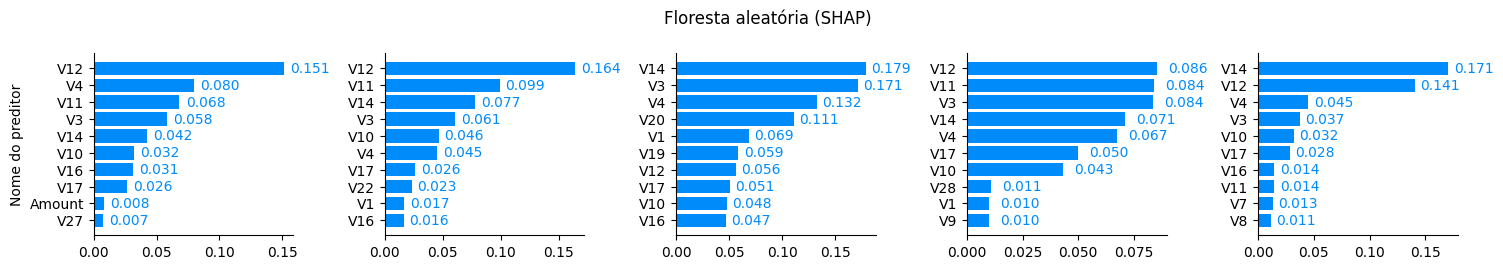

In [29]:
plot_shap_results_to_file(random_forest_results, "Floresta aleatória (SHAP)", "../results/new/kaggle/random_forest_feature_importance_plot(shap).pdf")

Time used to calculate SHAP values 0.013647079467773438 seconds! 

Time used to calculate SHAP values 0.014192819595336914 seconds! 

Time used to calculate SHAP values 0.013595342636108398 seconds! 

Time used to calculate SHAP values 0.013481378555297852 seconds! 

Time used to calculate SHAP values 0.013688802719116211 seconds! 



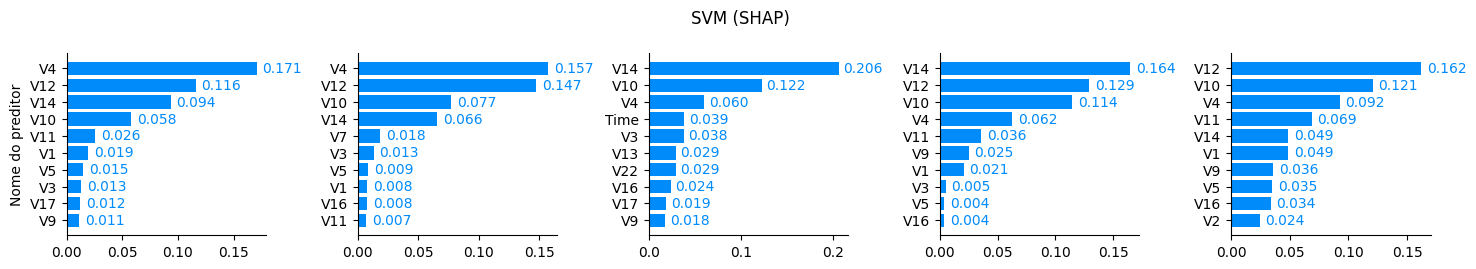

In [30]:
plot_shap_results_to_file(SVM_results, "SVM (SHAP)", "../results/new/kaggle/svm_feature_importance_plot(shap).pdf")

Time used to calculate SHAP values 0.044647932052612305 seconds! 

Time used to calculate SHAP values 0.04029393196105957 seconds! 

Time used to calculate SHAP values 0.02727985382080078 seconds! 

Time used to calculate SHAP values 0.027034997940063477 seconds! 

Time used to calculate SHAP values 0.02707362174987793 seconds! 



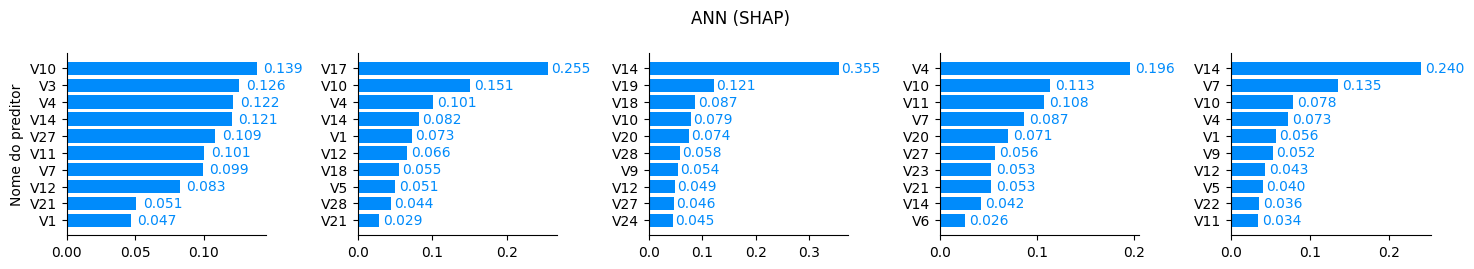

In [31]:
plot_shap_results_to_file(mlp_results, "ANN (SHAP)", "../results/new/kaggle/ann_feature_importance_plot(shap).pdf")

## LIME plots

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Time used to calculate LIME values 0.0440831184387207 seconds! 

Time used to calculate LIME values 0.04486489295959473 seconds! 

Time used to calculate LIME values 0.045235633850097656 seconds! 

Time used to calculate LIME values 0.045536041259765625 seconds! 



X does not have valid feature names, but LogisticRegression was fitted with feature names


Time used to calculate LIME values 0.047872304916381836 seconds! 



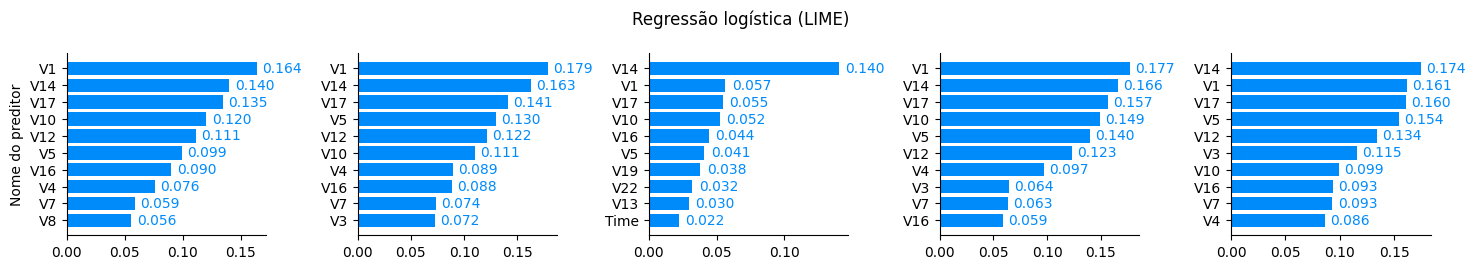

In [32]:
plot_lime_results_to_file(logistic_regression_results, "Regressão logística (LIME)", "../results/new/kaggle/logistic_regression_feature_importance_plot(lime).pdf")

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


Time used to calculate LIME values 0.044225215911865234 seconds! 

Time used to calculate LIME values 0.0452728271484375 seconds! 

Time used to calculate LIME values 0.046488046646118164 seconds! 

Time used to calculate LIME values 0.04571366310119629 seconds! 



X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


Time used to calculate LIME values 0.049926042556762695 seconds! 



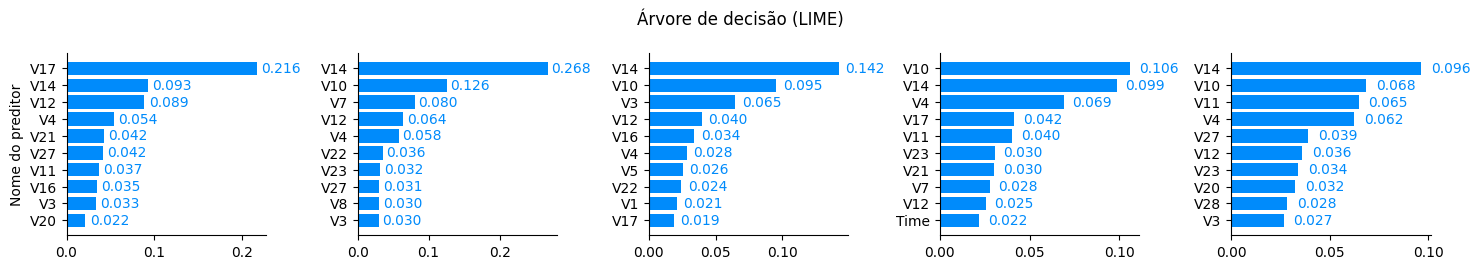

In [33]:
plot_lime_results_to_file(decision_tree_results, "Árvore de decisão (LIME)", "../results/new/kaggle/decision_tree_feature_importance_plot(lime).pdf")

X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Time used to calculate LIME values 0.19666600227355957 seconds! 

Time used to calculate LIME values 0.10849213600158691 seconds! 



X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Time used to calculate LIME values 0.12293791770935059 seconds! 

Time used to calculate LIME values 0.07389187812805176 seconds! 



X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Time used to calculate LIME values 0.13208389282226562 seconds! 



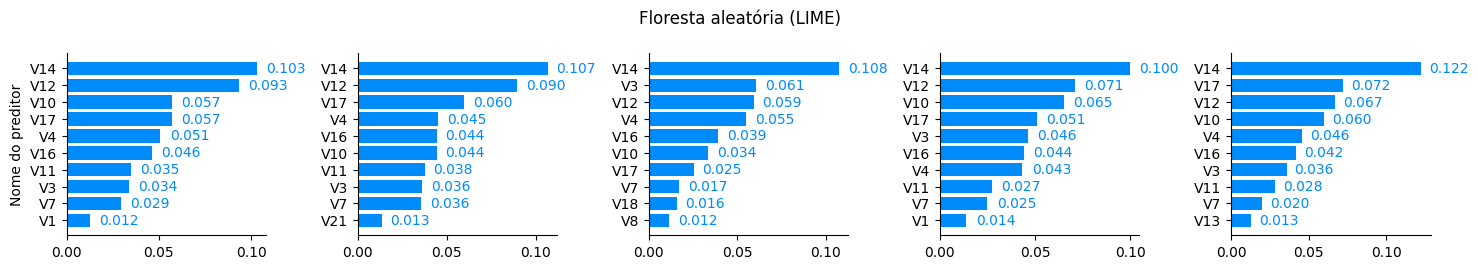

In [34]:
plot_lime_results_to_file(random_forest_results, "Floresta aleatória (LIME)", "../results/new/kaggle/random_forest_feature_importance_plot(lime).pdf")

X does not have valid feature names, but LinearSVC was fitted with feature names
X does not have valid feature names, but LinearSVC was fitted with feature names
X does not have valid feature names, but LinearSVC was fitted with feature names
X does not have valid feature names, but LinearSVC was fitted with feature names


Time used to calculate LIME values 0.04359269142150879 seconds! 

Time used to calculate LIME values 0.0449368953704834 seconds! 

Time used to calculate LIME values 0.04553675651550293 seconds! 

Time used to calculate LIME values 0.04576516151428223 seconds! 



X does not have valid feature names, but LinearSVC was fitted with feature names


Time used to calculate LIME values 0.04925870895385742 seconds! 



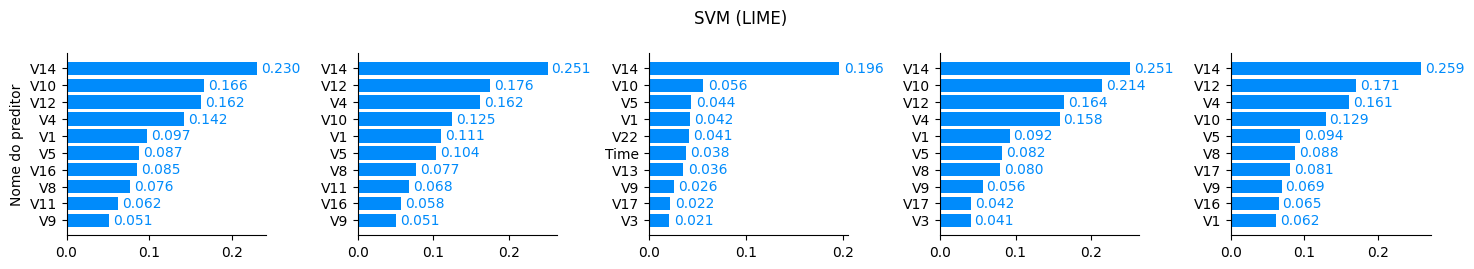

In [35]:
plot_lime_results_to_file_for_svm(SVM_results, "SVM (LIME)", "../results/new/kaggle/svm_feature_importance_plot(lime).pdf")

X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names


Time used to calculate LIME values 0.04604744911193848 seconds! 

Time used to calculate LIME values 0.04765009880065918 seconds! 

Time used to calculate LIME values 0.04665088653564453 seconds! 

Time used to calculate LIME values 0.04762983322143555 seconds! 



X does not have valid feature names, but MLPClassifier was fitted with feature names


Time used to calculate LIME values 0.05046200752258301 seconds! 



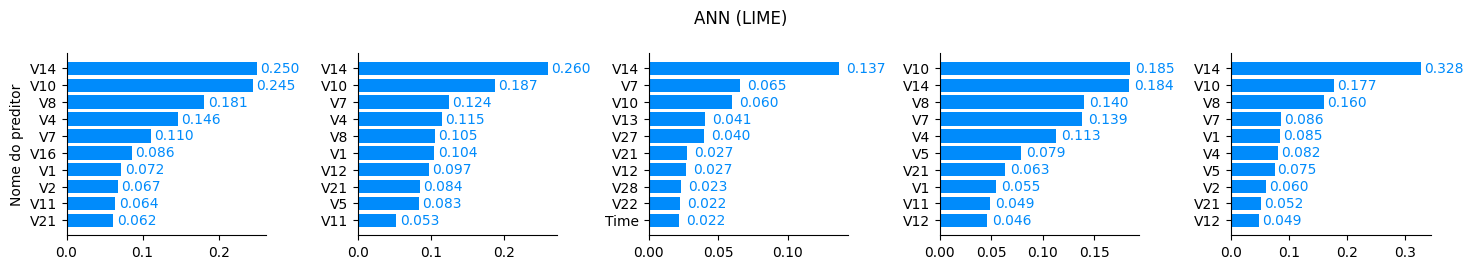

In [36]:
plot_lime_results_to_file(mlp_results, "ANN (LIME)", "../results/new/kaggle/ann_feature_importance_plot(lime).pdf")

## LIME and SHAP comparison data

In [37]:
def compute_agreement(data_dict):
    logistic_regression_values = data_dict['logistic_regression_values']
    num_agreements = {}
    for key in ['logistic_regression_lime', 'logistic_regression_shap', 'random_forest_lime', 'random_forest_shap', 'svm_lime', 'svm_shap', 'mlp_classifier_lime', 'mlp_classifier_shap', 'decision_tree_lime', 'decision_tree_shap']:
        num_agreements[key] = [sum([1 for s in data_dict[key][i] if s in logistic_regression_values[i]]) for i in range(len(logistic_regression_values))]
    return num_agreements

In [38]:
res = compute_agreement(data_dict)
print(res)

{'logistic_regression_lime': [8, 8, 7, 7, 8], 'logistic_regression_shap': [8, 9, 4, 8, 9], 'random_forest_lime': [8, 7, 5, 7, 7], 'random_forest_shap': [7, 8, 6, 7, 7], 'svm_lime': [9, 9, 7, 7, 7], 'svm_shap': [9, 8, 6, 7, 8], 'mlp_classifier_lime': [6, 7, 5, 7, 7], 'mlp_classifier_shap': [6, 7, 3, 4, 7], 'decision_tree_lime': [6, 4, 8, 7, 6], 'decision_tree_shap': [6, 5, 6, 6, 7]}
